In [1]:
import cv2
import face_recognition as fr
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import load_model
import numpy as np
from scipy.spatial import distance as dist
from collections import Counter
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Auxilary functions

#### Get frames

In [2]:
def get_frames(filename):
    frames = []
    cap = cv2.VideoCapture(filename)

    while(cap.isOpened()):
        ret, frame = cap.read()
                
        if not ret:
            break;
            
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(image)

    cap.release()
    cv2.destroyAllWindows()
    return frames

#### Similarity scores

In [3]:
def get_similarity_scores(frames):
   
    scores = []
    for i in range(1, len(frames)):
        frame = frames[i]
        prev_frame = frames[i-1]
        if(frame != [] and prev_frame!=[]):
            score = fr.face_distance(frames[i-1],frames[i][0])
        else:
            score=[1]            
        #(score, diff) = compare_ssim(frame, prev_frame, full=True, multichannel=True)
        scores.append(score[0])
    return scores

#### find face

In [4]:
def OpenCV_DNN_highlight_face(frame):    
        
    faceBoxes = []
    resultImg=frame.copy()
    frameHeight=resultImg.shape[0]
    frameWidth=resultImg.shape[1]        
    blob=cv2.dnn.blobFromImage(resultImg, 1.1, (300, 300), [104, 117, 123], True, False)
    
    #face detection is done with cnn
    faceNet.setInput(blob)
    detections=faceNet.forward()
    
    for i in range(detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>conf_threshold:           
            x1=int(detections[0,0,i,3]*frameWidth)
            y1=int(detections[0,0,i,4]*frameHeight)
            x2=int(detections[0,0,i,5]*frameWidth)
            y2=int(detections[0,0,i,6]*frameHeight)
            faceBoxes.append([x1,y1,x2,y2])
            
        
    return resultImg, faceBoxes

#### Emotions detection

In [5]:
def detectEmo(frame,faceDetector, emoNet):
    
    #detect and highlight faces
    resultImg,faceBoxes = faceDetector(frame)        
    
    if not faceBoxes:
        print("No face detected")
    
    padding=20    
    
 
    emos=[]
    
    for faceBox in faceBoxes:
        faceBox = list(faceBox)
        #print(faceBox)
        face=frame[max(0,faceBox[1]-padding):
                   min(faceBox[3]+padding,frame.shape[0]-1),max(0,faceBox[0]-padding)
                   :min(faceBox[2]+padding, frame.shape[1]-1)]

       
        try:
            blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False, crop=False)

            emoNet.setInput(blob)
            emoPreds=emoNet.forward()
            emo=emoList[emoPreds[0].argmax()]
            emos.append(emo)
        except Exception as ex:
            print(ex)
            emos.append('Neutral')
       
       
        
    return '' if emos==[] else emos[0]

#### Eye roll detection

In [6]:
def get_eyes(frame, landmarks):
    x1,y1 = landmarks['left_eye'][0][0], landmarks['left_eye'][1][1]
    x2,y2 = landmarks['left_eye'][3][0], landmarks['left_eye'][5][1]
    shape1 = [(x1-5,y1-5), (x2+5,y2+5)]
        
    x11,y11 = landmarks['right_eye'][0][0], landmarks['right_eye'][1][1]
    x21,y21 = landmarks['right_eye'][3][0], landmarks['right_eye'][5][1]
    shape2 = [(x11-5,y11-5), (x21+5,y21+5)]
        
    left_eye = frame[shape1[0][1]:shape1[1][1],shape1[0][0]:shape1[1][0],:]
    right_eye = frame[shape2[0][1]:shape2[1][1],shape2[0][0]:shape2[1][0],:]
    return (left_eye, right_eye)

In [7]:
def fr_dnn_eye_roll_detect(frame,landmarks_collection,display=True):        
    resultImg=frame.copy() 
    eyes_rolled=[]
    for landmarks in landmarks_collection:
        
       #detecting the boundaries of both eyes
        
        left_eye, right_eye = get_eyes(frame,landmarks)
        l_img =  cv2.resize(left_eye, (30,20), interpolation = cv2.INTER_AREA)        
        x = np.expand_dims(l_img, axis=0)
        images = np.vstack([x])       
        l_prediction = lmodel.predict(images, batch_size=10)    
        
        r_img =  cv2.resize(right_eye, (30,20), interpolation = cv2.INTER_AREA)        
        x = np.expand_dims(r_img, axis=0)
        images = np.vstack([x])       
        r_prediction = rmodel.predict(images, batch_size=10)       
                
        eyes_rolled_flag =  l_prediction[0] >=0.5 and r_prediction[0] >=0.5
        eyes_text = "Eyes are rolled" if eyes_rolled_flag else "Eyes are not rolled"
        eyes_rolled.append(eyes_rolled_flag)
        if(display):
            (min_x,min_y,max_x,max_y) = find_bounding_coordinates_from_landmarks(landmarks) 
            cv2.rectangle(resultImg, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
            cv2.putText(resultImg, f'{eyes_text}', (min_x, min_y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0012*resultImg.shape[1],
                    (255,255,255), int(0.002*resultImg.shape[1]), cv2.LINE_AA)       
        
    return resultImg, eyes_rolled

#### Bounding box by landmarks

In [8]:
def find_bounding_coordinates_from_landmarks(landmarks):
    #find min y for face bounding box
    min_y = 1000000
    min_x = 1000000
        
    for (x,y) in landmarks['right_eyebrow']:
        if y< min_y:
            min_y=y
                
    for (x,y) in landmarks['left_eyebrow']:
        if y< min_y:
            min_y=y        
        
    #find the rest coordinates
    max_y = -1
    max_x = -1   
        
    for (x,y) in landmarks['chin']:
        if x < min_x:
            min_x=x
        if x > max_x:
            max_x=x    
        if y > max_y:
            max_y=y 
    return(min_x,min_y,max_x,max_y)   

#### smile detection

In [9]:
def is_smile(face,landmarks):    
    # Calculate the lips width    
    left_lip_edge = np.array(landmarks['top_lip'][0])
    right_lip_edge = np.array(landmarks['top_lip'][6])
    lips_width = np.abs(left_lip_edge[0]-right_lip_edge[0])    
    face_width = np.abs(landmarks['chin'][2][0] - landmarks['chin'][14][0])   
    return  lips_width/face_width >=0.5   

In [10]:
def fr_smile_detect(frame,landmarks_collection,display=True):        
    resultImg=frame.copy()
    smiles = []
    for landmarks in landmarks_collection:        
        smiled = is_smile(resultImg,landmarks)
        smile_text='No smile' if not smiled else "Smile"            
        smiles.append(smiled)
        if display:        
            (min_x,min_y,max_x,max_y) = find_bounding_coordinates_from_landmarks(landmarks)    
                
            cv2.rectangle(resultImg, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
            cv2.putText(resultImg, f'{smile_text}', (min_x, min_y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0012*resultImg.shape[1],
                    (255,255,255), int(0.002*resultImg.shape[1]), cv2.LINE_AA)       
        
    return resultImg,smiles

#### Blink detecton

In [11]:
def get_ear(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3]) 
    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C) 
    # return the eye aspect ratio
    return ear

In [12]:
def fr_blink_detect(frame,landmarks_collection,display=True):        
    resultImg=frame.copy()       
    eyes_opened_closed = []
    for landmarks in landmarks_collection:
        left_eye = landmarks['left_eye']
        right_eye = landmarks['right_eye']
        ear_right = get_ear(right_eye)
        ear_left = get_ear(left_eye)    
                       
        eyes_closed =  ear_right < 0.16 and ear_left < 0.16
        #print(ear_left,ear_right)
        eyes_opened_closed.append(eyes_closed)
        if display:
            (min_x,min_y,max_x,max_y) = find_bounding_coordinates_from_landmarks(landmarks)            
            eyes_text = "Eyes are closed" if eyes_closed else "Eyes are opened"        
            cv2.rectangle(resultImg, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
            cv2.putText(resultImg, f'{eyes_text}', (min_x, min_y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0012*resultImg.shape[1],
                    (255,255,255), int(0.002*resultImg.shape[1]), cv2.LINE_AA)       
        
    return resultImg,eyes_opened_closed

#### Liveness detection

In [13]:
def liveness_statistics(frames):
    smile_prev_state = []
    smile_current_state=[]
    smiles_stat=[]

    er_prev_state = []
    er_current_state=[]
    er_stat=[]

    blink_prev_state =[]
    blink_current_state=[]
    blinks_stat=[]

    for frame in frames:
        landmarks_collection = fr.face_landmarks(frame)
    
        #smiles detection
        frame, smiles_vector=fr_smile_detect(frame, landmarks_collection,False)
        smile_current_state = [smile for smile in smiles_vector]
        if smiles_stat==[]:
            smiles_stat= [0 for smile in smiles_vector]
        
        #blinks detection
        frame, blinks_vector=fr_blink_detect(frame, landmarks_collection,False)
        blink_current_state = [blink for blink in blinks_vector]
        if blinks_stat==[]:
            blinks_stat= [0 for blink in blinks_vector]    
        
        #blinks detection
        frame, er_vector=fr_dnn_eye_roll_detect(frame, landmarks_collection,False)
        er_current_state = [er for er in er_vector]
        if er_stat==[]:
            er_stat= [0 for er in er_vector]    
            
        
        #print(smile_current_state,blink_current_state)    
  
               
        for i in range(len(smiles_vector)):
            (min_x,min_y,max_x,max_y) = find_bounding_coordinates_from_landmarks(landmarks_collection[i])
            #cv2.rectangle(frame, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
            #smiles
            smiled=False
            if smile_current_state[i] and (smile_prev_state!=[] and not smile_prev_state[i]):
                smiled=True           
        
            if(smiled):
                smiles_stat[i]+=1
            
            #eye rolls
            eye_rolled=False
            if er_current_state[i] and (er_prev_state!=[] and not er_prev_state[i]):
                eye_rolled=True           
        
            if(eye_rolled):
                er_stat[i]+=1
            
            #blinks
            blinked=False
            if blink_current_state[i] and (blink_prev_state!=[] and not blink_prev_state[i]):
                blinked=True           
            
            if(blinked):
                blinks_stat[i]+=1
            
        smile_prev_state=smile_current_state  
        blink_prev_state=blink_current_state
        er_prev_state=er_current_state
        # Displays the result on camera feed   
    return smiles_stat, er_stat,blinks_stat

#### Plots

In [14]:
def plot_alalysis(frames_enc,cemo):
    fig, axes = plt.subplots(2, 1, figsize=(20, 15))
    axes =  axes.flatten()
    
    axes[0].plot(get_similarity_scores(frames_enc[:-1]), "or",ms=2)
    axes[0].set_xlabel("Frame No.")
    axes[0].set_ylabel("Similarity score")
    axes[0].set_title("Distribution of pairwise (current and previous frames) similarity score")

    emotions = list(cemo.keys())
    values = list(cemo.values())
  
 
    # creating the bar plot
    axes[1].bar(emotions, values, color ='maroon',
        width = 0.4)
 
    axes[1].set_xlabel("Emotions offered")
    axes[1].set_ylabel("counter")
    axes[1].set_title("Distribution of emotions")



#### Get frames

In [15]:
frames = get_frames('demo_kyc3.avi')

In [16]:
len(frames)

1322

In [27]:
sample = frames[:400]

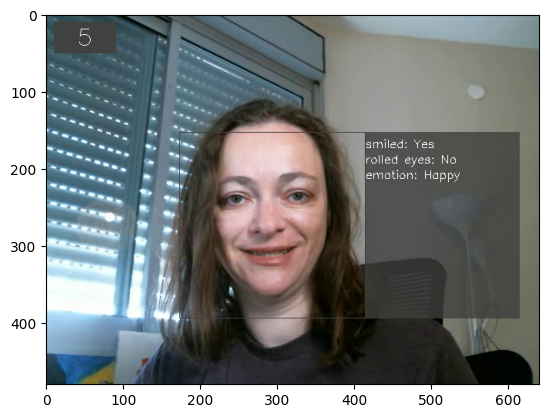

In [19]:
plt.imshow(frames[700])

#### initialize emotion detector

In [20]:
emoProto ="models/wild/deploy.prototxt" 
emoModel="models/wild/EmotiW_VGG_S.caffemodel"
emoList = [ 'Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise']



emoNet =cv2.dnn.readNet(emoModel,emoProto,)


faceProto="models/wild/opencv_face_detector.pbtxt"
faceModel="models/wild/opencv_face_detector_uint8.pb"


#confidence threshold for face detection
conf_threshold=0.7
MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)

faceNet=cv2.dnn.readNet(faceModel,faceProto)

In [21]:
lmodel = load_model('../liveness/data/left_eye.h5')
rmodel = load_model('../liveness/data/right_eye.h5')

#### Build frame set from one single frame

In [22]:
frames_same = [frames[700]]*500

In [23]:
len(frames_same)

500

#### Build frame set from 100 frames by repeating them 5 times

In [24]:
frames_cycle = frames[300:800]*5

#### Build frames set with eepfakes:
take first 500 frames
insert depfake instead of every legal frame

In [25]:
fake =  cv2.cvtColor(cv2.imread('../deepfake/images/images_for_tests/fake4.jpg'), cv2.COLOR_BGR2RGB)

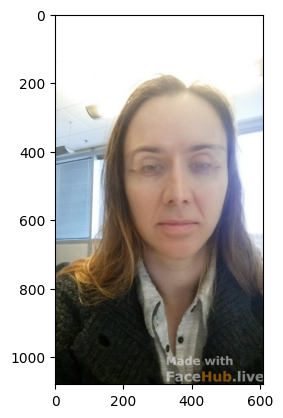

In [26]:
plt.imshow(fake)

In [27]:
frames_fake=[frame if i%100 !=0 else fake for i,frame in enumerate(frames[:500])]

In [28]:
len(frames_fake)

500

#### Original image:

* calculate pairwise similarity scores
* calculate emotions of frames, group them by emotion
* calculate liveness statistics
* draw plot of pairwise similarity scores and a bar plot of grouped emotions

In [29]:
start = time.time()
frames_enc = [fr.face_encodings(frames[i]) for i in range(len(frames))]
end = time.time()
print(end - start)

808.1206364631653


In [30]:
emotions = [detectEmo(frame,OpenCV_DNN_highlight_face,emoNet) for frame in frames]

No face detected
No face detected


In [31]:
cemo = Counter(emotions)

In [32]:
cemo

Counter({'Fear': 608,
         'Neutral': 134,
         'Surprise': 6,
         'Happy': 393,
         'Sad': 179,
         '': 2})

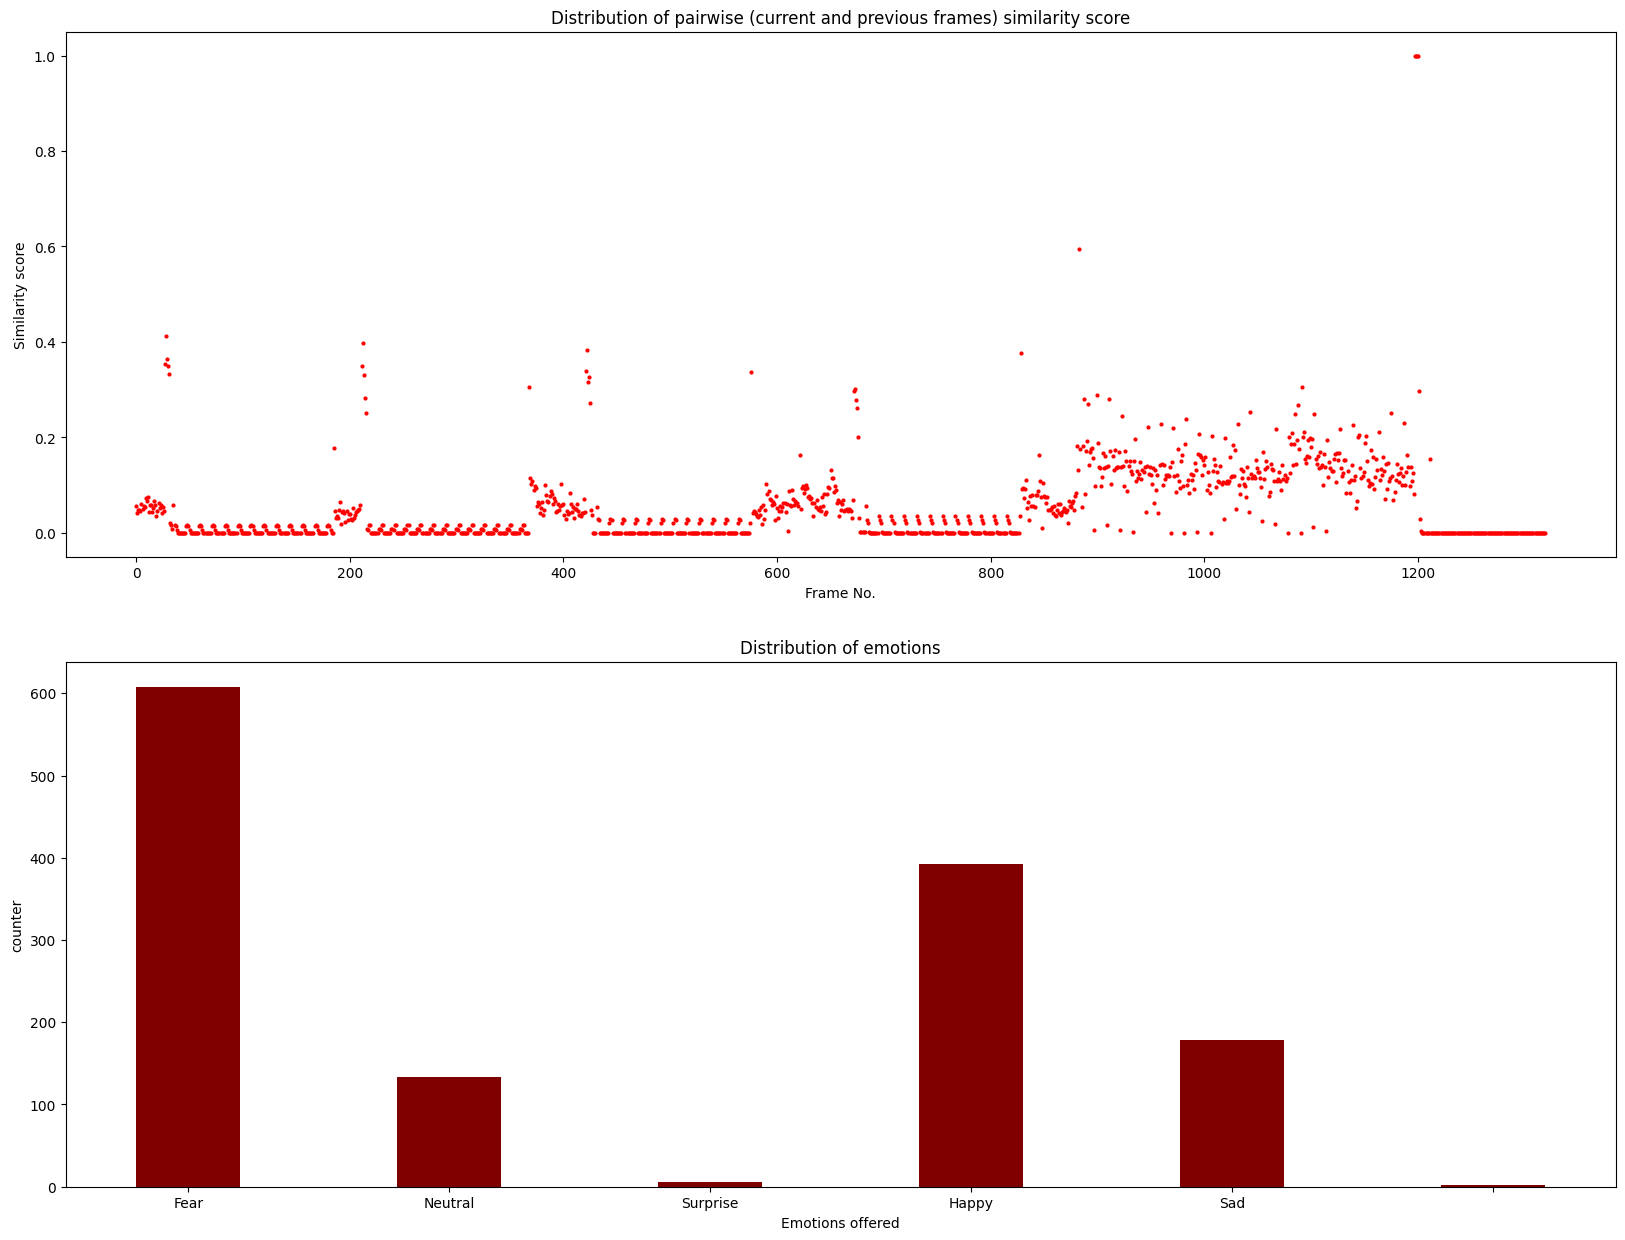

In [33]:
plot_alalysis(frames_enc,cemo)

In [34]:
smiles_stat, er_stat,blinks_stat =  liveness_statistics(frames)   
print(smiles_stat, er_stat,blinks_stat)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 32ms/step
[4] [4] [6]


#### Video buld from single frame:

* calculate pairwise similarity scores
* calculate emotions of frames, group them by emotion
* calculate liveness statistics
* draw plot of pairwise similarity scores and a bar plot of grouped emotions

In [35]:
start = time.time()
frames_same_enc = [fr.face_encodings(frames_same[i]) for i in range(len(frames_same))]
end = time.time()
print(end - start)

312.62375497817993


In [36]:
emotions_same = [detectEmo(frame,OpenCV_DNN_highlight_face,emoNet) for frame in frames_same]

In [37]:
cemo1 = Counter(emotions_same)

In [38]:
cemo1

Counter({'Happy': 500})

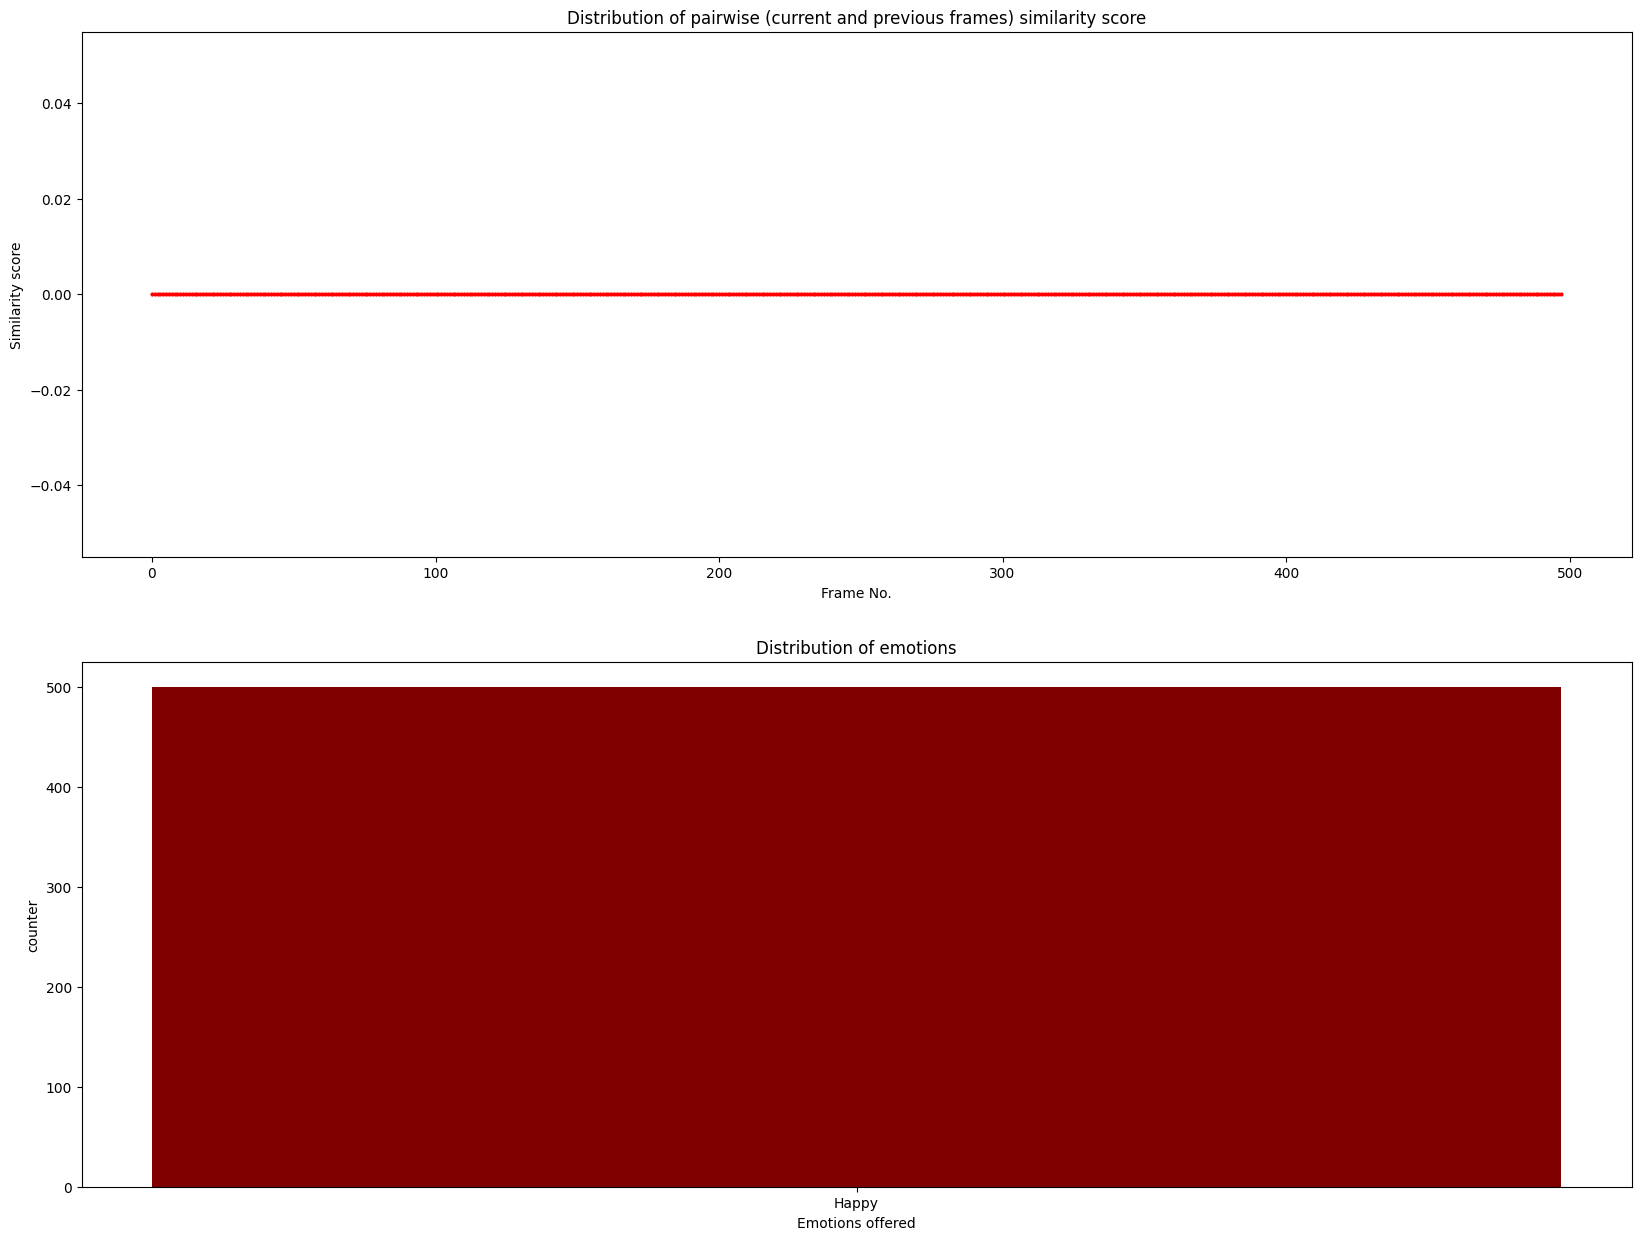

In [39]:
plot_alalysis(frames_same_enc,cemo1)

In [40]:
smiles_stat1, er_stat1,blinks_stat1 =  liveness_statistics(frames_same)   
print(smiles_stat1, er_stat1,blinks_stat1)

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 35ms/step
[0] [0] [0]


#### Video built from a 100 frames repeated 5 times:

* calculate pairwise similarity scores
* calculate emotions of frames, group them by emotion
* calculate liveness statistics
* draw plot of pairwise similarity scores and a bar plot of grouped emotions

In [41]:
start = time.time()
frames_cycle_enc = [fr.face_encodings(frames_cycle[i]) for i in range(len(frames_cycle))]
end = time.time()
print(end - start)

1728.148607492447


In [42]:
len(frames_cycle)

2500

In [43]:
emotions_cycle = [detectEmo(frame,OpenCV_DNN_highlight_face,emoNet) for frame in frames_cycle]

In [ ]:
#frames_fake

In [44]:
cemo2 = Counter(emotions_cycle)

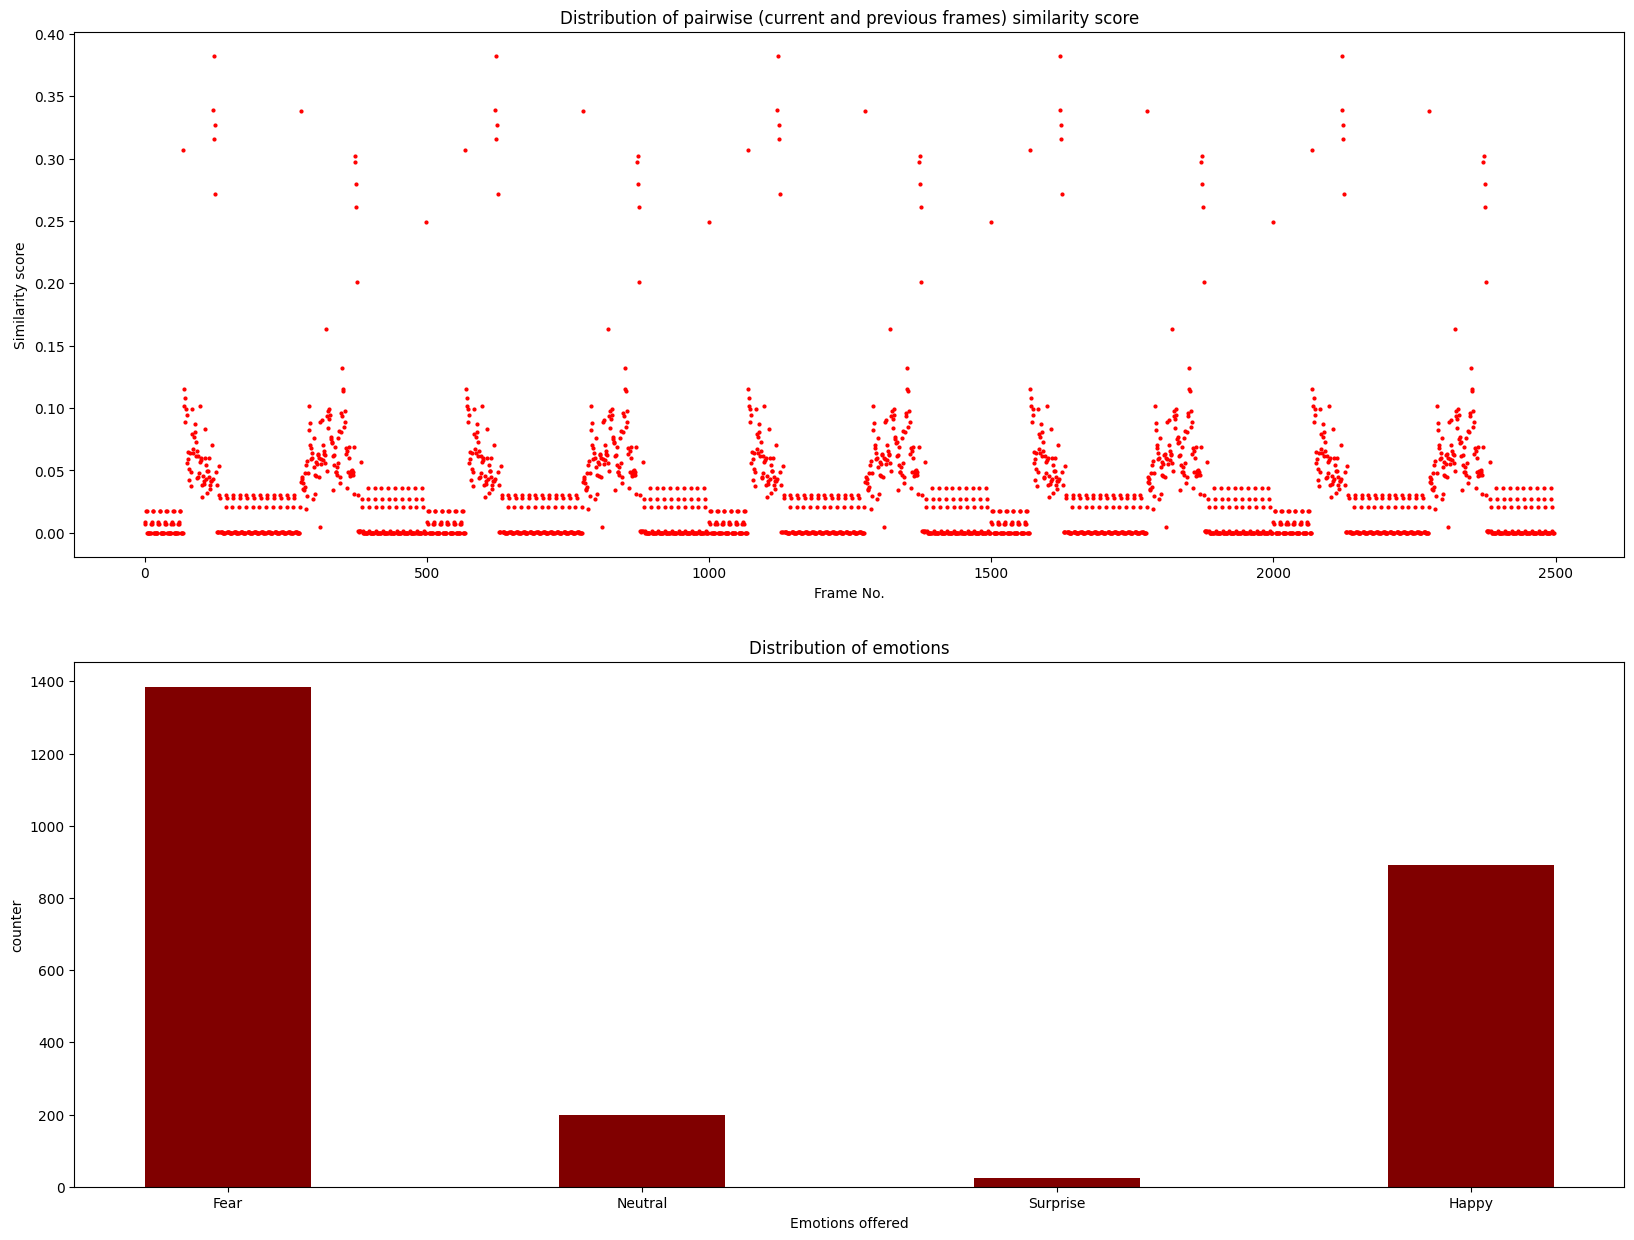

In [45]:
plot_alalysis(frames_cycle_enc,cemo2)

In [46]:
smiles_stat2, er_stat2,blinks_stat2 =  liveness_statistics(frames_cycle)   
print(smiles_stat2, er_stat2,blinks_stat2)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 29ms/step
[20] [20] [15]


#### Video built from first 500 frames, each 100-th is replaced with a deepfake

* calculate pairwise similarity scores
* calculate emotions of frames, group them by emotion
* calculate liveness statistics
* draw plot of pairwise similarity scores and a bar plot of grouped emotions

In [47]:
start = time.time()
frames_fake_enc = [fr.face_encodings(frames_fake[i]) for i in range(len(frames_fake))]
end = time.time()
print(end - start)

360.7297885417938


In [48]:
emotions_fake = [detectEmo(frame,OpenCV_DNN_highlight_face,emoNet) for frame in frames_fake]

In [49]:
cemo3 = Counter(emotions_fake)

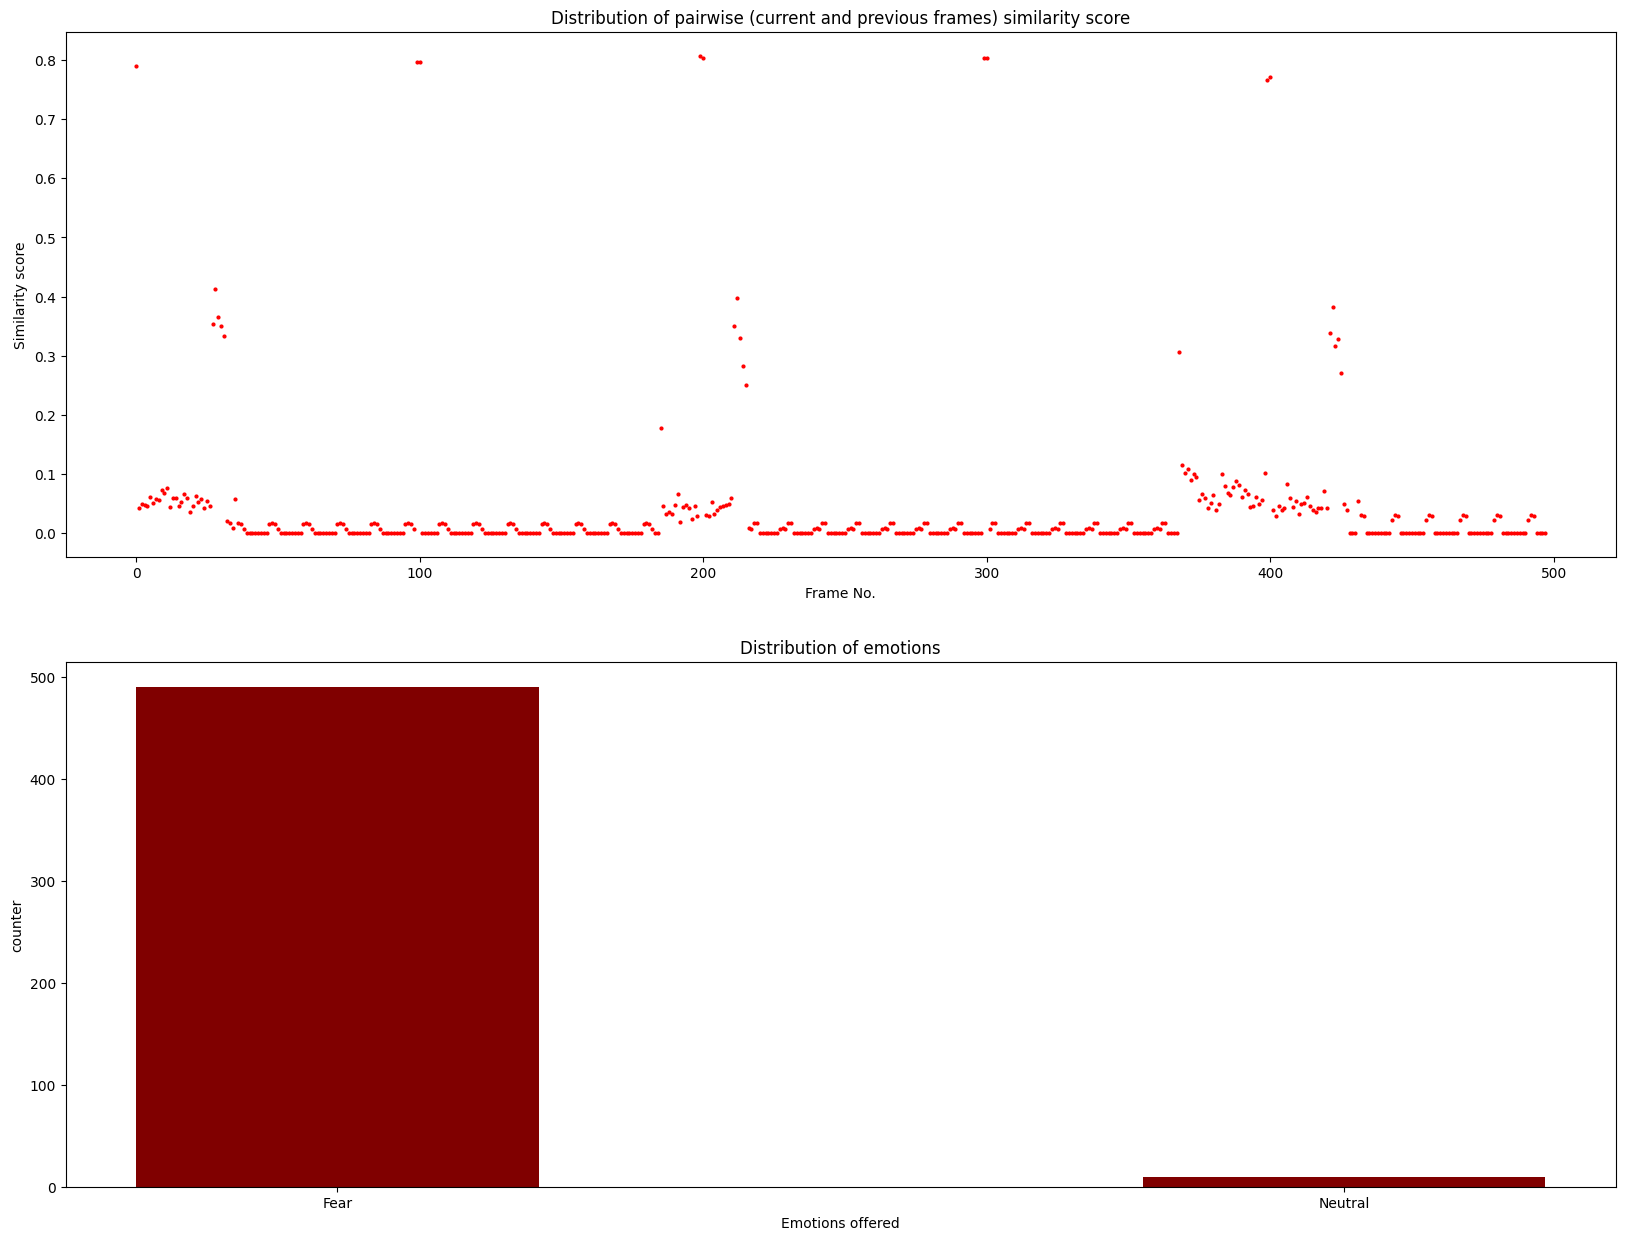

In [50]:
plot_alalysis(frames_fake_enc,cemo3)

In [51]:
smiles_stat3, er_stat3,blinks_stat3 =  liveness_statistics(frames_fake)   
print(smiles_stat3, er_stat3,blinks_stat3)

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step
[0] [5] [4]
